# ECSE415 - Into to Computer Vision
## Assignment 4
### Alexander Harris - 260688155

## 1 - Data Acquisition

In [1]:
import cv2
import numpy as np
import os
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [2]:
def plotFigures(images, labels):
    """
    Plots images from list in grid.
    
    images: list of images
    title: title for each subplot
    params: specific arguments to add to title
    """
    grid_len = math.ceil(math.sqrt(len(images)))
    plt.figure(figsize=(30,30))
    i = 0
    for image, label in zip(images, labels):
        plt.subplot(grid_len, grid_len, i+1), plt.imshow(image, 'gray')
        plt.title('{} - #{}'.format(label, i+1)), plt.axis('off')
        i += 1
    plt.show()

In [3]:
def extract_face(img, class_face, size):
    """
    Crop face from original image and resize.
    
    img: image to crop
    class_face: classifier to use
    """
    detect = class_face.detectMultiScale(img, 1.1, 4)
    x, y, w, h = detect[0]
    face = img[y:y+h, x:x+w]
    face_resized = cv2.resize(face, size)
    return face_resized

In [4]:
# Classifier used for testing and prepping training data
face_cascade = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_default.xml'))

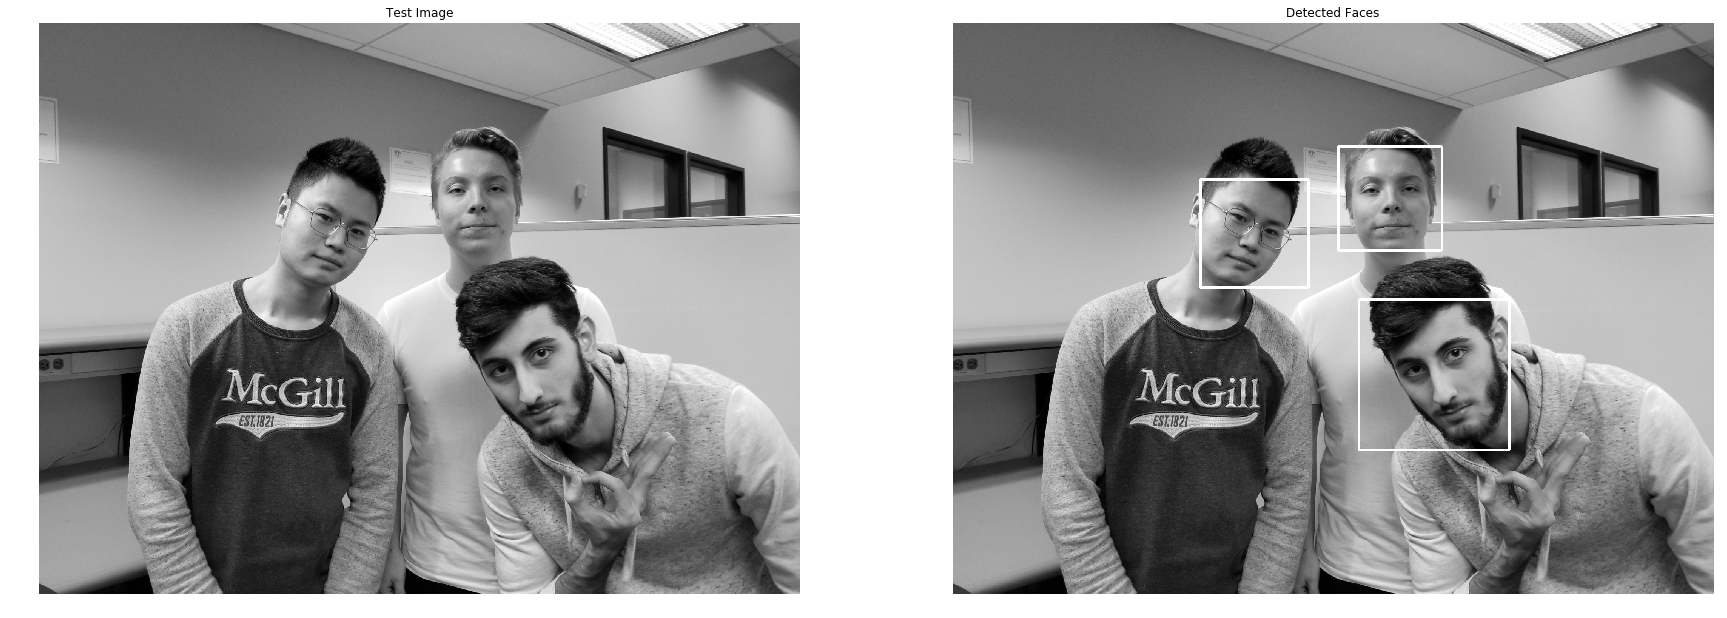

In [44]:
# Show faces detected in test image
test_path = './dataset/test/'
test_file = os.listdir(test_path)[0]
test_img = cv2.imread(test_path + test_file, cv2.IMREAD_GRAYSCALE)
test_img_resized = cv2.resize(test_img, None, fx=0.5, fy=0.5)
test_faces = face_cascade.detectMultiScale(test_img_resized, 1.21, 3)

detected_faces = test_img_resized.copy()
for (x, y, w, h) in test_faces:
    cv2.rectangle(detected_faces, (x,y), (x+w,y+h), (255,255,255), 5)

plt.figure(figsize=(30,30))
plt.subplot(121), plt.title('Test Image')
plt.imshow(test_img_resized, cmap='gray'), plt.axis('off')
plt.subplot(122), plt.title('Detected Faces')
plt.imshow(detected_faces, cmap='gray'), plt.axis('off')
plt.show()

In [66]:
# Import training images and crop around faces
train_path = './dataset/train/'
train_classes = os.listdir(train_path)

train_faces = []
train_labels = []
for train_class in train_classes:
    filenames = os.listdir(train_path + train_class + '/')
    for i, file in enumerate(filenames):
        img = cv2.imread('{}{}/{}'.format(train_path, train_class, file), cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, None, fx=0.5, fy=0.5)
        face = extract_face(img_resized, face_cascade, (128,128))
        train_faces.append(face)
        train_labels.append(train_class)

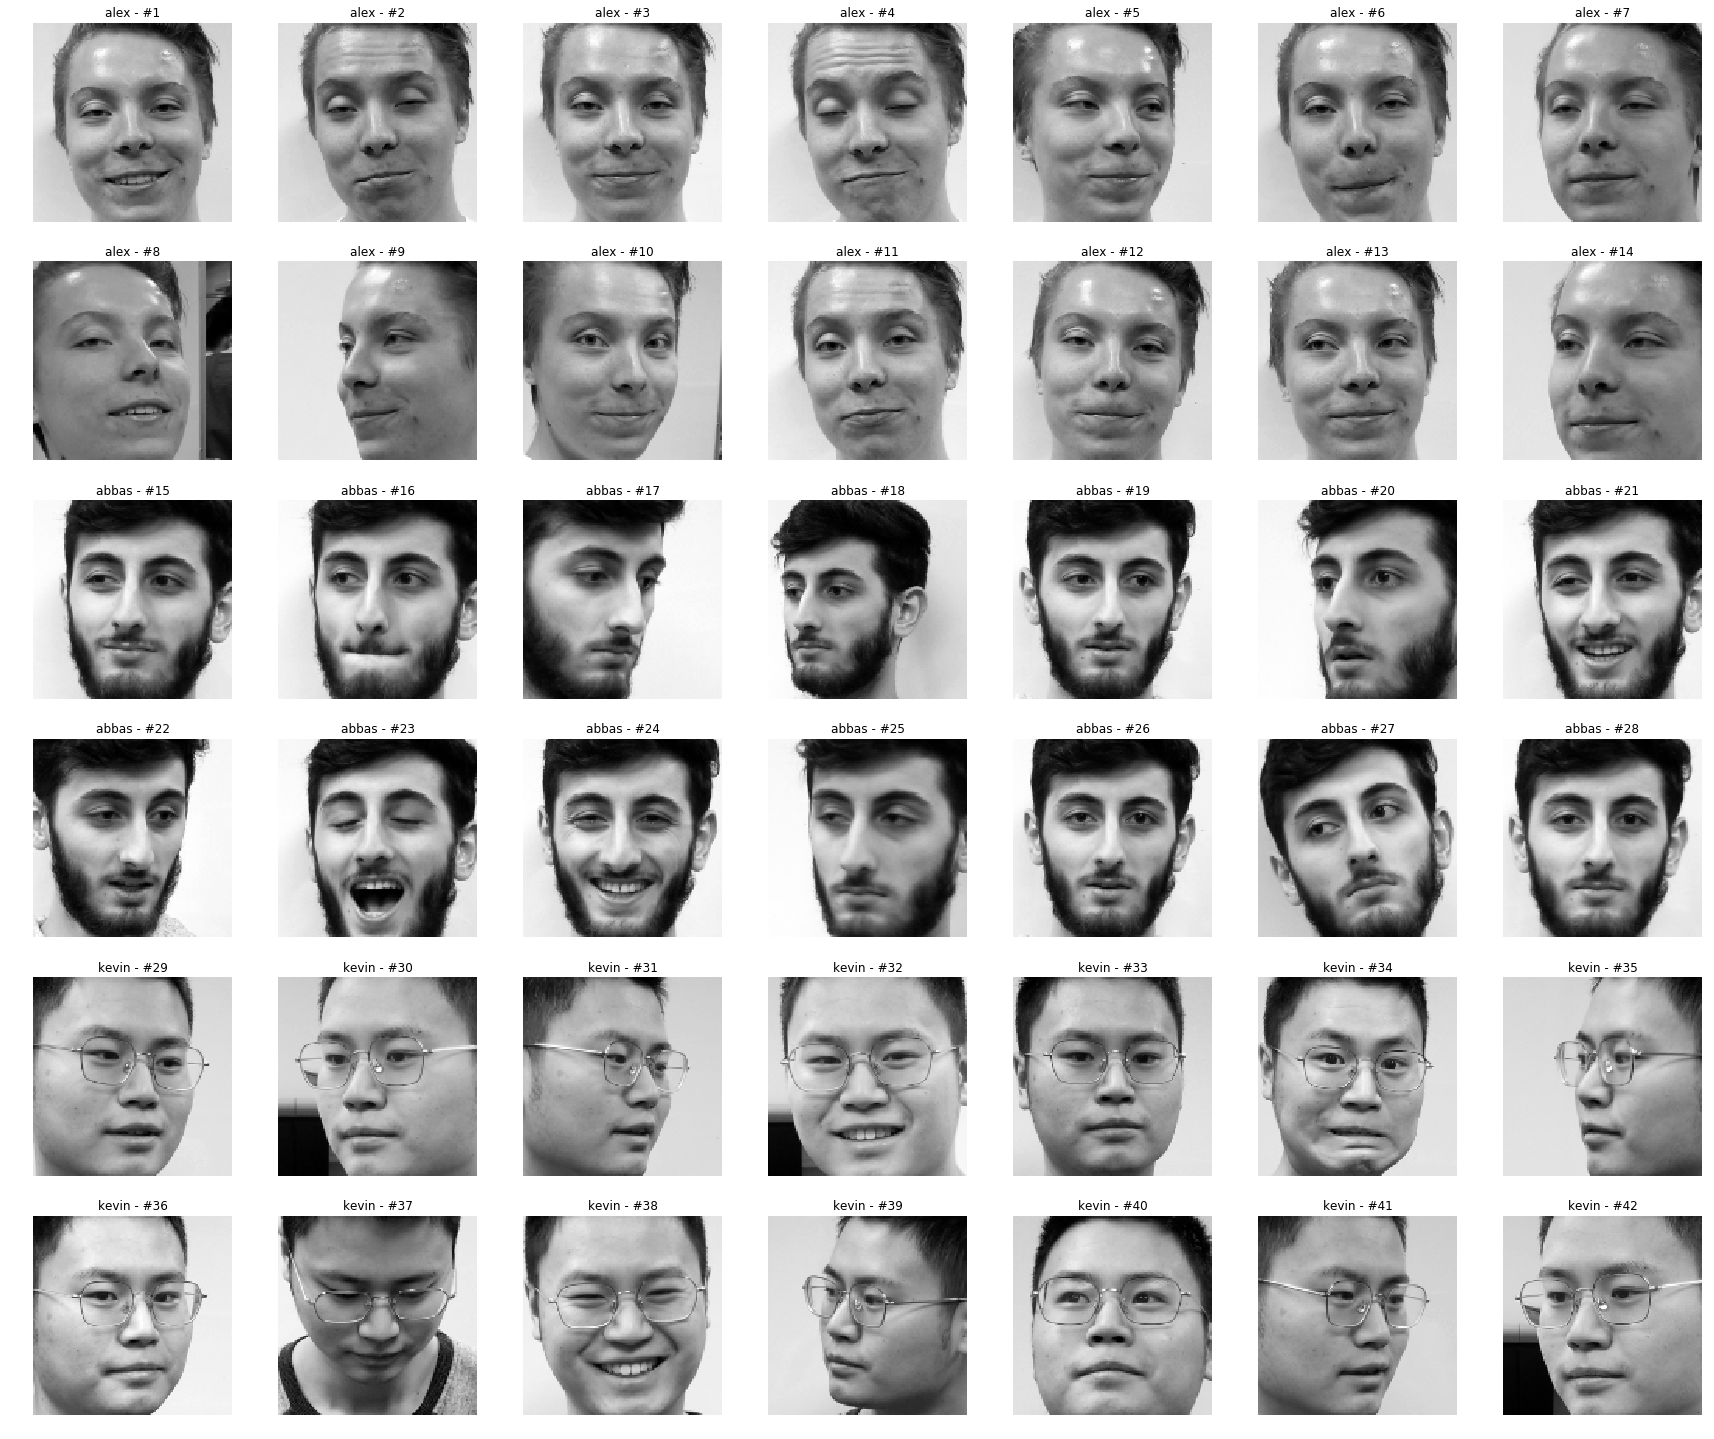

In [67]:
plotFigures(train_faces, train_labels)

We tried to select images that matched the faces from the group image as much as possible. Thats is to say, since the group picture was taken close to a decade ago, we needed to make sure we sourced pictures of the individual actors from the same time-period, with similar facial hair, facial expressions, hairstyle, eyewear, etc. We also made sure to not select pictures with significant occlusion from hands or head position.

## 2 - Eigenvector Representation

In [68]:
# Split training data
x_train, x_test, y_train, y_test = train_test_split(train_faces, train_labels, test_size=0.2, train_size=0.8)
x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)
pca = PCA(n_components=3)

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Compute PCA
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

print(x_train_pca.shape)
print(pca.explained_variance_ratio_)

(33, 3)
[0.27082099 0.22323069 0.09435375]


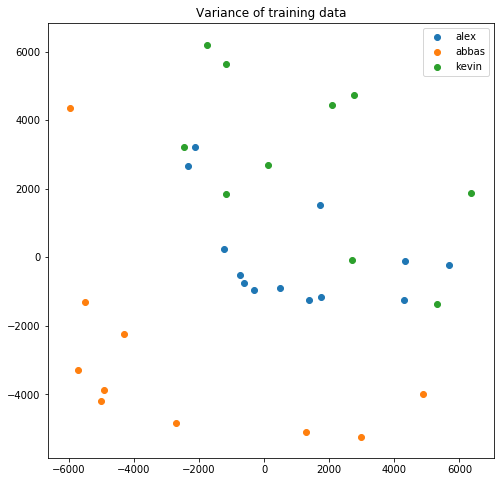

In [82]:
# Select matching data and plot
matching_data = []
plt.figure(figsize=(8,8))
for img_class in train_classes:
    x_class = x_train_pca[y_train == img_class, :]
    plt.scatter(x_class[:,0], x_class[:,1])
plt.title('Variance of training data')
plt.legend(train_classes)
plt.show()

In [80]:
log_reg = LogisticRegression(solver='liblinear', multi_class='auto')
log_reg.fit(x_train, y_train)
prediction = log_reg.predict_proba(x_test)
print(log_loss(y_test, prediction))

log_reg.fit(x_train_pca, y_train)
prediction = log_reg.predict_proba(x_test_pca)
print(log_loss(y_test, prediction))

0.0002664704220483064
0.19134368042708733
